In [1]:
# 1. 라이브러리 임포트
import pymc as pm
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import pytensor.tensor as pt
import pytensor
pytensor.config.mode == 'NUMBA'

np.random.seed(42)

# 2. 데이터 생성 (가상) - 제공된 코드와 동일
# --- 컴퓨터 모델(시뮬레이터) 데이터 ---
N_c = 25
X_c_np = np.linspace(0, 1, N_c)
theta_c_np = np.linspace(0, 1, N_c)
Xc_theta_c_np = np.vstack([X_c_np, theta_c_np]).T
def computer_model(x, theta): return (x + 0.5) * np.sin(theta * 2 * np.pi) + x**2
y_c = computer_model(X_c_np, theta_c_np) + np.random.normal(0, 0.02, size=N_c)

# --- 실제 물리 실험 데이터 ---
N_p = 10
X_p_np = np.linspace(0, 1, N_p)
theta_true = 0.6
def physical_process(x, theta):
    discrepancy = np.sin(x * 4 * np.pi) * 0.1
    return computer_model(x, theta) + discrepancy
y_p = physical_process(X_p_np, theta_true) + np.random.normal(0, 0.05, size=N_p)


# 3. PyMC로 KOH 보정 모델 구축
with pm.Model() as koh_model:
    ### --- (수정) pm.Data로 모델 유연성 확보 --- ###
    # 예측 시 X_p의 값을 새로운 값으로 교체할 수 있도록 pm.Data로 감싸줍니다.
    X_p_shared = pm.Data('X_p_shared', X_p_np[:, None])
    y_p_shared = pm.Data('y_p_shared', y_p)
    # --- 우리가 찾으려는 보정 파라미터 θ의 사전분포 ---
    theta = pm.Uniform("theta", lower=0.0, upper=1.0)

    # --- 1. 컴퓨터 모델 에뮬레이터 GP (η) ---
    ls_eta = pm.Gamma("ls_eta", alpha=2, beta=0.5, shape=2)
    eta_eta = pm.HalfCauchy("eta_eta", beta=2)
    cov_eta = eta_eta**2 * pm.gp.cov.ExpQuad(input_dim=2, ls=ls_eta)
    gp_eta = pm.gp.Latent(cov_func=cov_eta)

    # --- 2. 불일치 함수 GP (δ) ---
    ls_delta = pm.Gamma("ls_delta", alpha=2, beta=0.5)
    eta_delta = pm.HalfCauchy("eta_delta", beta=2)
    cov_delta = eta_delta**2 * pm.gp.cov.ExpQuad(input_dim=1, ls=ls_delta)
    gp_delta = pm.gp.Latent(cov_func=cov_delta)

    # --- 3. 가능도(Likelihood) 정의 ---
    # 컴퓨터 모델 데이터에 대한 가능도
    f_c = gp_eta.prior("f_c", X=Xc_theta_c_np)
    sigma_c = pm.HalfNormal("sigma_c", sigma=0.05)
    y_c_obs = pm.Normal("y_c_obs", mu=f_c, sigma=sigma_c, observed=y_c)

    # 물리적 실험 데이터에 대한 가능도
    Xp_theta = pt.concatenate([X_p_shared, pt.tile(theta, (X_p_shared.shape[0], 1))], axis=1)
    f_p_eta = gp_eta.prior("f_p_eta", X=Xp_theta)
    f_p_delta = gp_delta.prior("f_p_delta", X=X_p_shared)
    
    # 두 부분을 더해서 최종 예측 평균을 계산
    mu_p = f_p_eta + f_p_delta
    
    ### --- (추가) 예측 시 쉽게 접근할 수 있도록 Deterministic 변수로 저장 --- ###
    mu_p_final = pm.Deterministic("mu_p_final", mu_p)
    
    # 관측 노이즈
    sigma_p = pm.HalfNormal("sigma_p", sigma=0.1)
    y_p_obs = pm.Normal("y_p_obs", mu=mu_p_final, sigma=sigma_p, observed=y_p_shared)

    ### --- (추가) 4. MCMC 샘플링 실행 --- ###
    trace = pm.sample(300, tune=300, chains=2)


Initializing NUTS using jitter+adapt_diag...
/home/lsw91/Workspace/pymc-gp/.venv/lib/python3.11/site-packages/pytensor/link/c/cmodule.py:2968: UserWarning: PyTensor could not link to a BLAS installation. Operations that might benefit from BLAS will be severely degraded.
This usually happens when PyTensor is installed via pip. We recommend it be installed via conda/mamba/pixi instead.
Alternatively, you can use an experimental backend such as Numba or JAX that perform their own BLAS optimizations, by setting `pytensor.config.mode == 'NUMBA'` or passing `mode='NUMBA'` when compiling a PyTensor function.
For more options and details see https://pytensor.readthedocs.io/en/latest/troubleshooting.html#how-do-i-configure-test-my-blas-library
  warnings.warn(
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta, ls_eta, eta_eta, ls_delta, eta_delta, f_c_rotated_, sigma_c, f_p_eta_rotated_, f_p_delta_rotated_, sigma_p]


Output()

/home/lsw91/Workspace/pymc-gp/.venv/lib/python3.11/site-packages/pymc/step_methods/hmc/quadpotential.py:316: RuntimeWarning: overflow encountered in dot
  return 0.5 * np.dot(x, v_out)
/home/lsw91/Workspace/pymc-gp/.venv/lib/python3.11/site-packages/pytensor/tensor/blas.py:1238: RuntimeWarning: overflow encountered in dot
  z[0] = np.asarray(scalar * np.dot(x, y))


Sampling 2 chains for 300 tune and 300 draw iterations (600 + 600 draws total) took 191 seconds.
There were 271 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


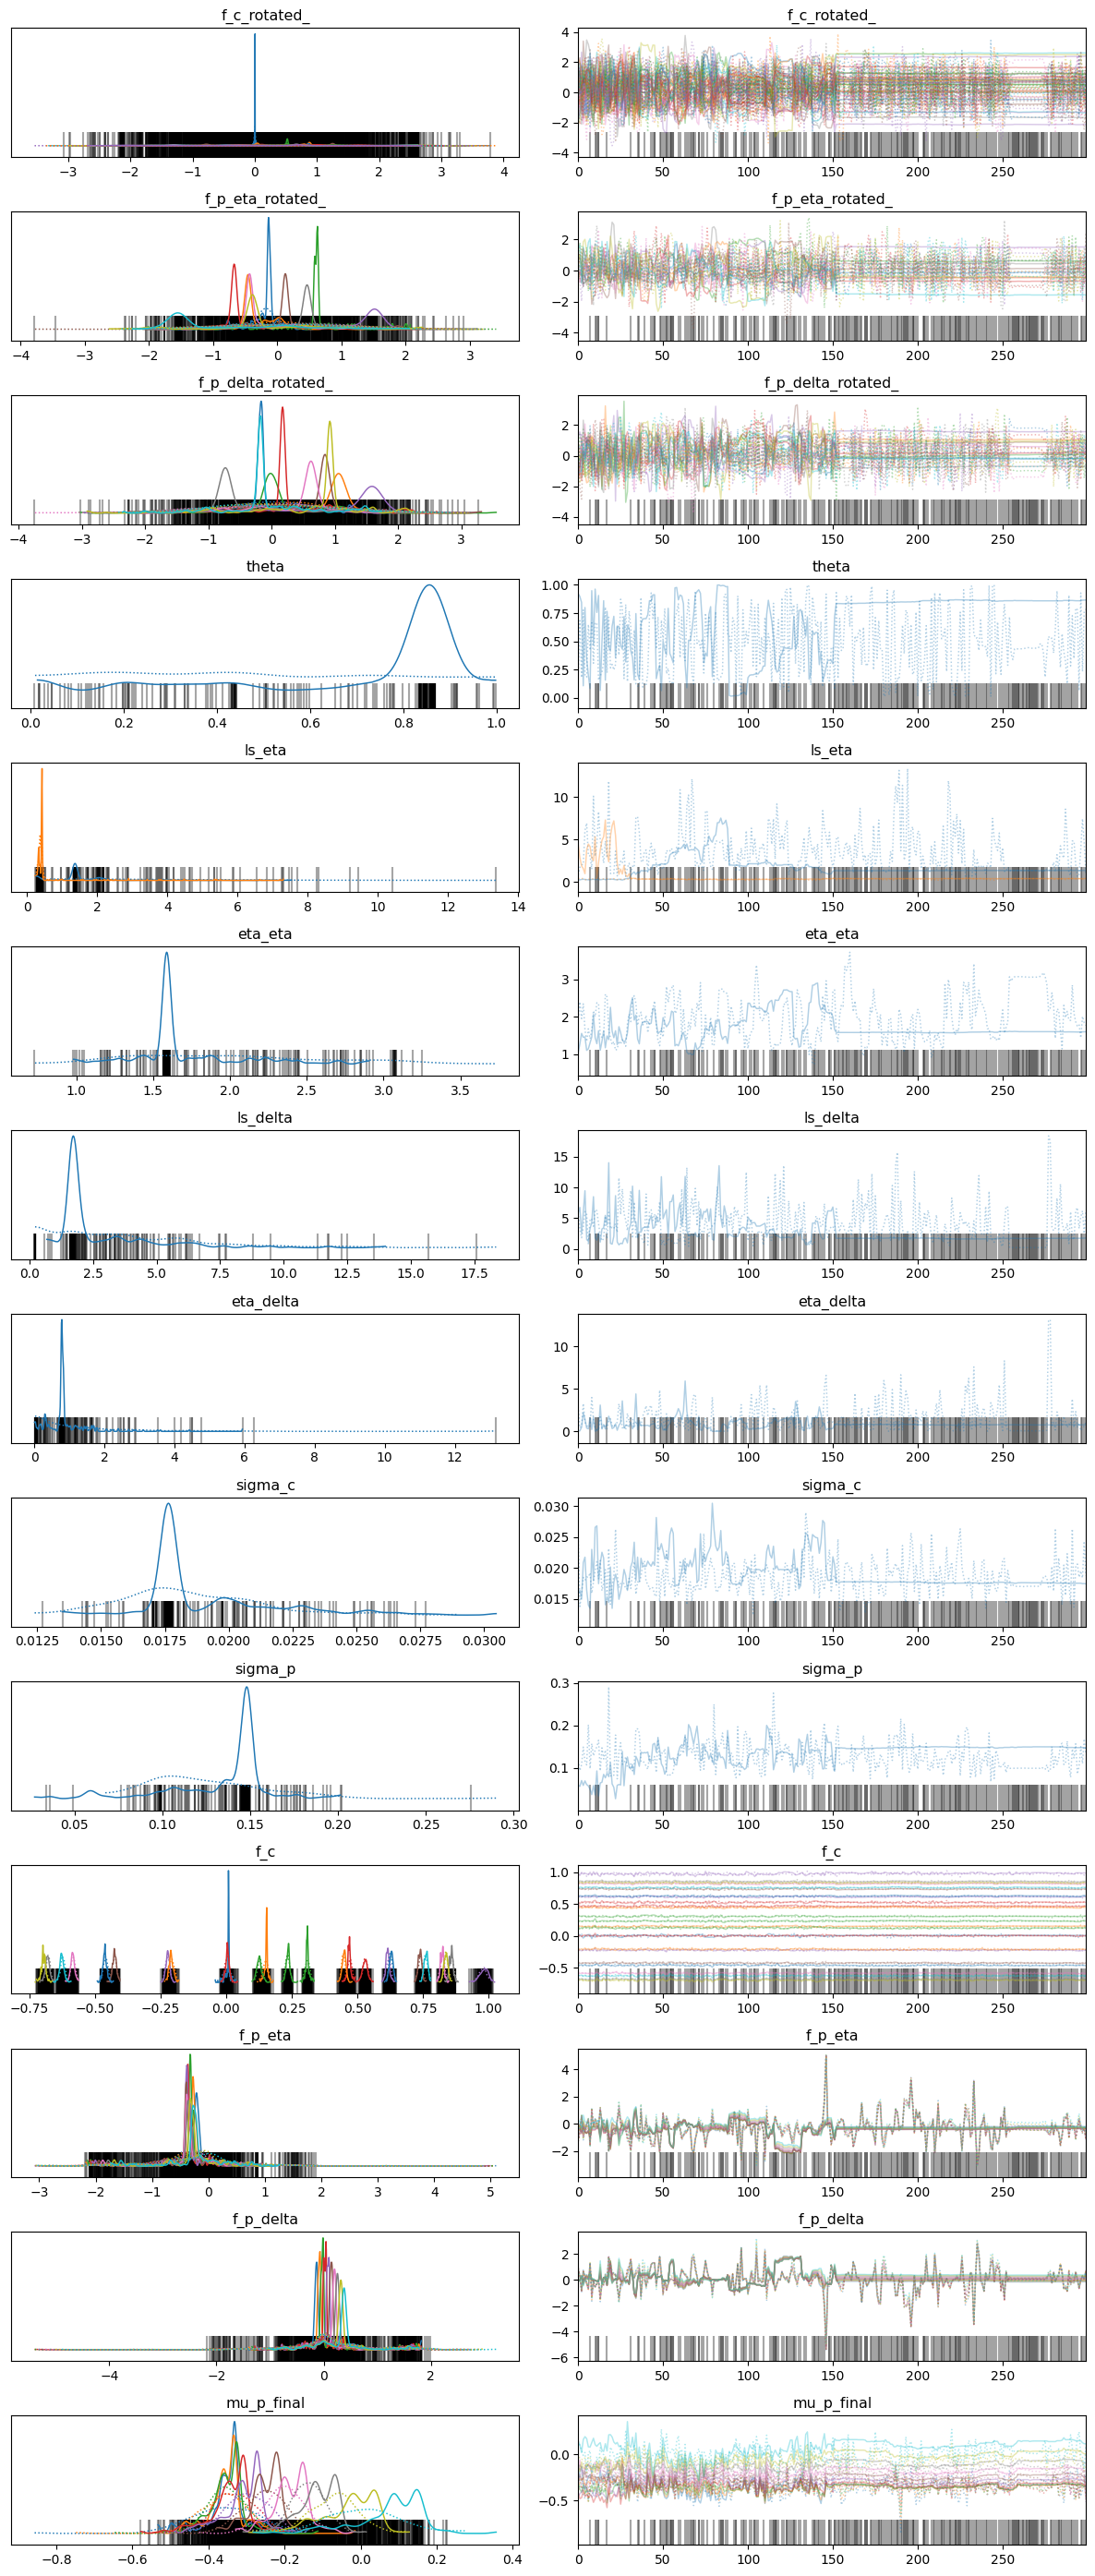

In [2]:
az.plot_trace(trace)
plt.tight_layout()
plt.show()

In [3]:
# --- 새로운 X에 대한 후험 예측 수행 ---
X_new = np.linspace(-0.5, 1.5, 100)[:, None]

with koh_model:
    # ✅ X_p_shared는 X_new로, y_p_shared는 None으로 설정합니다.
    pm.set_data({
        'X_p_shared': X_new,
        'y_p_shared': np.zeros(len(X_new)) # y_p_shared에 shape을 맞춰주기 위한 더미 데이터. 값은 사용되지 않음.
                                           # None을 지원하지 않는 현재 버전의 이슈로 더미 데이터를 넣어줌.
    })

    posterior_predictive = pm.sample_posterior_predictive(
        trace,
        var_names=["y_p_obs", "mu_p_final"],
        # ✅ observed를 사용하지 않도록 설정
        predictions=False,
    )

Sampling: [f_p_delta_rotated_, f_p_eta_rotated_, y_p_obs]


Output()

In [51]:
posterior_predictive

Inference data with groups:
	> posterior_predictive
	> observed_data
	> constant_data

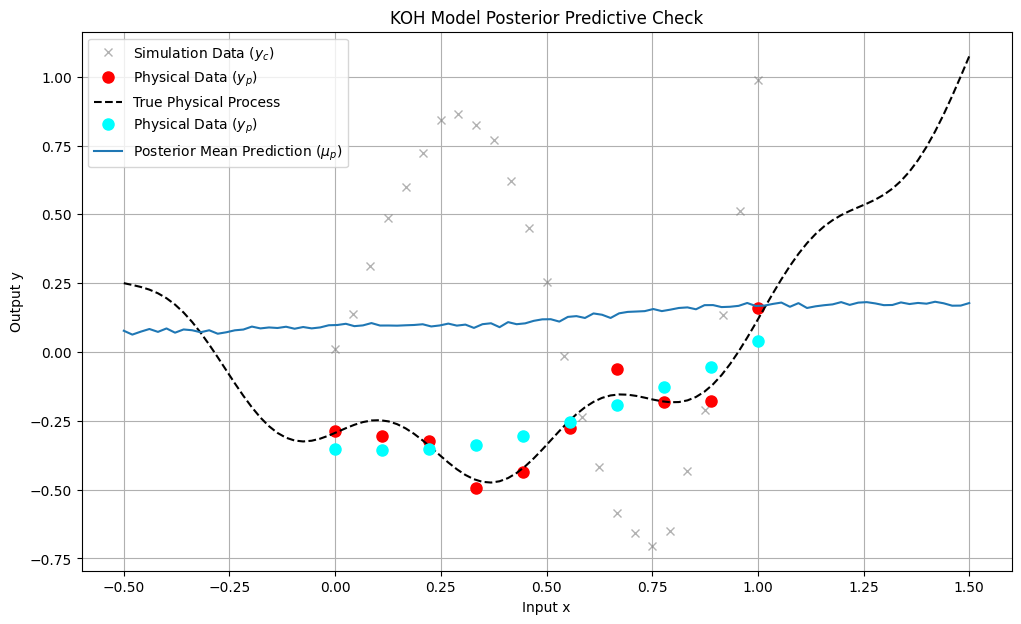

In [4]:

### --- (추가) 6. 결과 시각화 --- ###

plt.figure(figsize=(12, 7))

# 후험 예측 샘플에서 데이터 추출
# pred_samples = az.extract(posterior_predictive.predictions)
# pred_samples = posterior_predictive.predictions
pred_samples = posterior_predictive.posterior_predictive
y_pred = pred_samples['y_p_obs']
mu_pred = pred_samples['mu_p_final']

# 예측값의 평균과 신뢰구간(HDI) 계산
mu_mean = mu_pred.mean(axis=(0, 1))
y_hdi = az.hdi(y_pred, hdi_prob=0.94)['y_p_obs'].values
mu_hdi = az.hdi(mu_pred, hdi_prob=0.94)['mu_p_final'].values

mu_mean2 = trace.posterior["mu_p_final"].values.mean(axis=(0, 1))
# y_hdi = az.hdi(trace.posterior["y_p_obs"].values, hdi_prob=0.94)['y_p_obs'].values
# mu_hdi = az.hdi(trace.posterior["mu_p_final"].values, hdi_prob=0.94)['mu_p_final'].values

# 원본 데이터 플로팅
plt.plot(X_c_np, y_c, 'x', color='gray', alpha=0.6, label='Simulation Data ($y_c$)')
plt.plot(X_p_np, y_p, 'o', color='red', markersize=8, label='Physical Data ($y_p$)')
plt.plot(X_new.ravel(), physical_process(X_new.ravel(), theta_true), '--', color='black', label='True Physical Process')

# 샘플된 예측 결과 플로팅
plt.plot(X_p_np, mu_mean2, 'o', color='cyan', markersize=8, label='Physical Data ($y_p$)')
# plt.show()


# 예측 결과 플로팅
plt.plot(X_new.ravel(), y_pred.mean(axis=(0, 1)), color='C0', label='Posterior Mean Prediction ($\mu_{p}$)')
# # 평균에 대한 불확실성 (함수 자체의 불확실성)
# plt.fill_between(X_new.ravel(), mu_hdi[:, 0], mu_hdi[:, 1], color='C0', alpha=0.3, label='94% HDI for Mean')
# # 개별 관측값에 대한 불확실성 (함수 불확실성 + 관측 노이즈)
# plt.fill_between(X_new.ravel(), y_hdi[:, 0], y_hdi[:, 1], color='C0', alpha=0.15, label='94% HDI for Observation ($y_{p}$)')

plt.title('KOH Model Posterior Predictive Check')
plt.xlabel('Input x')
plt.ylabel('Output y')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

In [30]:
trace.posterior["mu_p_final"].values

array([[[-3.83325103e-01, -3.72261197e-01, -3.53314969e-01, ...,
         -1.42191815e-01, -8.40606373e-02, -2.51666923e-02],
        [-1.49845510e-01, -3.29572323e-01, -4.71141044e-01, ...,
         -1.83266945e-01, -7.50750363e-02,  3.50395383e-04],
        [-2.69285401e-01, -3.31631993e-01, -3.58263067e-01, ...,
         -5.42135777e-02,  1.19472216e-02,  5.58491577e-02],
        ...,
        [-3.69824924e-01, -3.41688886e-01, -3.18945425e-01, ...,
         -2.15333166e-01, -2.02628952e-01, -1.86491449e-01],
        [-4.71893700e-01, -4.17732894e-01, -3.66118695e-01, ...,
         -1.19930988e-01, -7.89914511e-02, -3.70590182e-02],
        [-4.43878652e-01, -3.87687521e-01, -3.34154537e-01, ...,
         -6.59237018e-02, -1.93782079e-02,  3.19027689e-02]],

       [[-2.38023682e-01, -2.55302115e-01, -3.69115514e-01, ...,
         -2.14092042e-01, -9.22042424e-02,  2.45000532e-01],
        [-3.38353453e-01, -2.90385204e-01, -3.83881929e-01, ...,
         -1.44772171e-01, -9.08060013e

In [1]:
# 1. 라이브러리 임포트
import pymc as pm
import numpy as np
import arviz as az
import matplotlib.pyplot as plt

np.random.seed(42)

# 2. 데이터 생성 (가상)

# --- 컴퓨터 모델(시뮬레이터) 데이터 ---
# 비싼 시뮬레이션을 25번 돌렸다고 가정
N_c = 25
# 시뮬레이션 입력 변수 (온도 x)
X_c = np.linspace(0, 1, N_c)
# 시뮬레이션에 사용한 보정 파라미터 (촉매 활성도 θ)
theta_c = np.linspace(0, 1, N_c)
# 시뮬레이션 입력 (x와 θ를 결합)
Xc_theta_c = np.vstack([X_c, theta_c]).T

# 컴퓨터 모델의 '진짜' 함수 (우리가 모른다고 가정)
def computer_model(x, theta):
    return (x + 0.5) * np.sin(theta * 2 * np.pi) + x**2

# 컴퓨터 모델 실행 결과 (약간의 수치적 노이즈 포함)
y_c = computer_model(X_c, theta_c) + np.random.normal(0, 0.02, size=N_c)


# --- 실제 물리 실험 데이터 ---
# 실제 실험은 10번 수행했다고 가정
N_p = 10
# 실제 실험에 사용한 입력 변수 (온도 x)
X_p = np.linspace(0, 1, N_p)

# '진짜' 보정 파라미터 값 (우리가 찾아야 할 값!)
theta_true = 0.6

# '진짜' 물리 현상 함수 (컴퓨터 모델 + 불일치 함수)
def physical_process(x, theta):
    # 불일치 함수 (모델이 예측 못하는 현상, 예: 특정 온도에서의 부작용)
    discrepancy = np.sin(x * 4 * np.pi) * 0.2
    return computer_model(x, theta) + discrepancy

# 실제 실험 관측 결과 (측정 노이즈 포함)
y_p = physical_process(X_p, theta_true) + np.random.normal(0, 0.05, size=N_p)


# 3. PyMC로 KOH 보정 모델 구축
with pm.Model() as koh_model:
    # --- 우리가 찾으려는 보정 파라미터 θ의 사전분포 ---
    # 촉매 활성도는 0과 1 사이 값이라고 가정
    theta = pm.Uniform("theta", lower=0.0, upper=1.0)

    # --- 1. 컴퓨터 모델 에뮬레이터 GP (η) ---
    # 하이퍼파라미터 사전분포
    ls_eta = pm.Gamma("ls_eta", alpha=2, beta=0.5, shape=2) # 입력이 2차원(x,θ)이므로 shape=2
    eta_eta = pm.HalfCauchy("eta_eta", beta=2)
    # 에뮬레이터 GP의 커널 정의
    cov_eta = eta_eta**2 * pm.gp.cov.ExpQuad(input_dim=2, ls=ls_eta)
    # 에뮬레이터 GP 정의
    gp_eta = pm.gp.Latent(cov_func=cov_eta)

    # --- 2. 불일치 함수 GP (δ) ---
    # 하이퍼파라미터 사전분포
    ls_delta = pm.Gamma("ls_delta", alpha=2, beta=0.5)
    eta_delta = pm.HalfCauchy("eta_delta", beta=2)
    # 불일치 GP의 커널 정의 (입력이 1차원(x)이므로 input_dim=1)
    cov_delta = eta_delta**2 * pm.gp.cov.ExpQuad(input_dim=1, ls=ls_delta)
    # 불일치 GP 정의
    gp_delta = pm.gp.Latent(cov_func=cov_delta)

    # --- 3. 가능도(Likelihood) 정의 ---
    # 컴퓨터 모델 데이터에 대한 가능도 (에뮬레이터 학습)
    f_c = gp_eta.prior("f_c", X=Xc_theta_c)
    # 수치적 안정성을 위한 작은 노이즈
    sigma_c = pm.HalfNormal("sigma_c", sigma=0.05)
    y_c_obs = pm.Normal("y_c_obs", mu=f_c, sigma=sigma_c, observed=y_c)

    # 물리적 실험 데이터에 대한 가능도 (보정 및 불일치 함수 학습)
    # 물리 실험 입력 X_p와 추정할 theta를 결합
    Xp_theta = pm.math.stack([X_p, theta * np.ones(N_p)]).T
    
    # 에뮬레이터 부분과 불일치 부분을 각각 계산
    f_p_eta = gp_eta.prior("f_p_eta", X=Xp_theta)
    f_p_delta = gp_delta.prior("f_p_delta", X=X_p[:, None])
    
    # 두 부분을 더해서 최종 예측 평균을 계산
    mu_p = f_p_eta + f_p_delta
    
    # 관측 노이즈
    sigma_p = pm.HalfNormal("sigma_p", sigma=0.1)
    y_p_obs = pm.Normal("y_p_obs", mu=mu_p, sigma=sigma_p, observed=y_p)




Initializing NUTS using jitter+adapt_diag...
/home/xlsw91/Workspace/pymc-gp/.venv/lib/python3.11/site-packages/pytensor/link/c/cmodule.py:2968: UserWarning: PyTensor could not link to a BLAS installation. Operations that might benefit from BLAS will be severely degraded.
This usually happens when PyTensor is installed via pip. We recommend it be installed via conda/mamba/pixi instead.
Alternatively, you can use an experimental backend such as Numba or JAX that perform their own BLAS optimizations, by setting `pytensor.config.mode == 'NUMBA'` or passing `mode='NUMBA'` when compiling a PyTensor function.
For more options and details see https://pytensor.readthedocs.io/en/latest/troubleshooting.html#how-do-i-configure-test-my-blas-library
  warnings.warn(
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Sequential sampling (2 chains in 1 job)
NUTS: [theta, l

Output()

Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 405 seconds.
There were 975 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


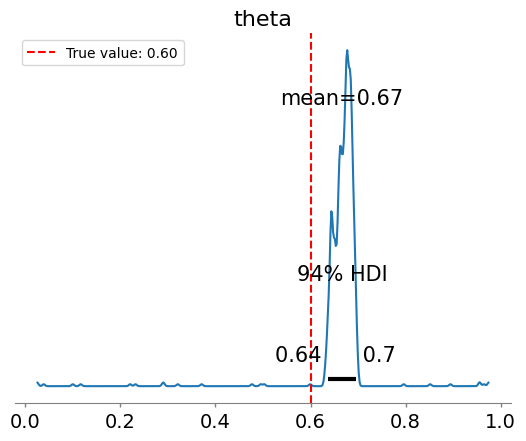

In [2]:
# 4. MCMC 추론 실행
with koh_model:
    trace = pm.sample(1000, tune=1000, cores=1)

# 5. 결과 분석
az.summary(trace, var_names=["theta", "ls_eta", "eta_eta", "ls_delta", "eta_delta", "sigma_p"])

# 보정 파라미터 theta의 사후 분포 시각화
az.plot_posterior(trace, var_names=["theta"])
plt.axvline(theta_true, color='r', linestyle='--', label=f"True value: {theta_true:.2f}")
plt.legend()
plt.show()

In [9]:
# 5. 새로운 데이터에 대한 예측
# ---------------------------
# 예측을 수행할 새로운 x좌표(X_new)를 촘촘하게 생성합니다.
Xnew = np.linspace(0, 1, 20)[:, None]

with koh_model:
    # gp.conditional 메서드는 학습된 사후 분포를 기반으로,
    # 새로운 입력 X_new에 대한 함수 값(f_new)의 분포를 계산해줍니다.
    gp = gp_eta + gp_delta
    f_pred = gp.conditional("f_pred", Xnew=Xnew)

ValueError: All covariances must have the same `input_dim`.

In [5]:
with koh_model:
    # 위에서 정의한 조건부 분포로부터 예측 샘플을 추출합니다.
    # 이것이 "사후 예측 샘플링" 과정입니다.
    pred_samples = pm.sample_posterior_predictive(trace, var_names=["f_pred"])

KeyError: 'f_pred'

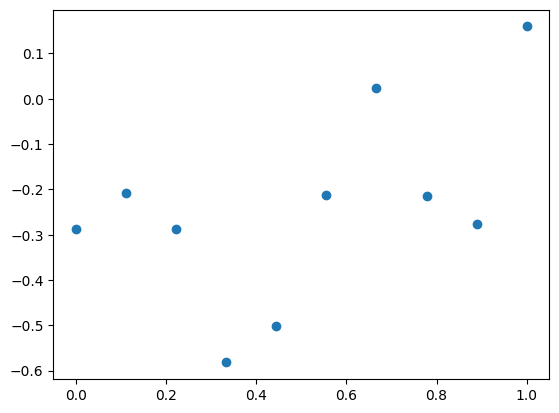

In [4]:
import matplotlib.pyplot as plt

plt.plot(X_p, y_p, 'o')

plt.show()